In [3]:
%store -r

In [ ]:
# read the polaris data for Boulder Couunty area slicing out parts of 1 degree segments
# Applicable components from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/Readme for
# Blue Spruce (Picea pungens) 
# Native Range latitude 33° 50' to 48° 54' N. and from longitude 104° 45' to 114° 00' W.
# Soil pH is 6.8 to 7.2, neutral to slightly alkaline
# Preference for Mollisols - soils that have a dark colored surface horizon relatively high in content of organic matter. 
# The soils are base rich throughout and therefore quite fertile. 
# Reference https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/mollisols
# also to a lesser extent, in the orders Histosols not in Colorado as per https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/histosols 
# and Inceptisols (page not working at https://www.nrcs.usda.gov/conservation-basics/natural-resource-concerns/soils/inceptisols)
# alternative https://en.wikipedia.org/wiki/Inceptisol
#
# for Mollisoils
# given the GGPT prompt described at https://docs.google.com/document/d/14sLLOeQOxcq4QF18y1n87_whPe-L5IbbmUMCpcOiXJ0/edit?usp=sharing
# silt	%	Generally high, around 30-50%, with a gradual decrease with depth.
# sand	%	Moderately low, around 20-40%, increasing with depth.
# clay	%	Moderate, around 20-40%, increasing with depth due to leaching and accumulation.
# bd (bulk density)	g/cm³	Low in surface layers due to organic matter, around 1.1-1.3 g/cm³, increasing to 1.4-1.6 g/cm³ in deeper layers.
# theta_s	m³/m³	High in organic-rich topsoil, around 0.40-0.50, decreasing slightly with depth.
# theta_r	m³/m³	Low, around 0.05-0.10 for most depths.
# ksat	log10(cm/hr)	Moderately high in surface layers due to organic matter, around 1.0-2.0 log10(cm/hr), decreasing in lower layers to 0.0-1.0 log10(cm/hr).
# ph	N/A	Neutral to slightly basic, around 6.5-7.5 in surface layers, may vary slightly with depth but generally remains neutral.
# om (organic matter)	log10(%)	High in surface layers, around 1.0-2.0 log10(%), sharply decreasing with depth to <0.5 log10(%) beyond 30 cm.
# lambda	N/A	Moderately high in surface layers, around 0.3-0.6, indicative of good water retention properties, decreasing with depth.
# hb	log10(kPa)	Low in surface layers, around 1.0-1.5 log10(kPa), increasing with depth due to soil compaction and smaller pore spaces.
# n (pore size distribution, van Genuchten)	N/A	Around 1.2-1.5, indicating moderate pore size uniformity in the surface layers, may increase slightly with depth.
# alpha	log10(kPa⁻¹)	Around -2.0 to -2.5 log10(kPa⁻¹), reflecting the moderately high pore sizes in surface layers, decreasing slightly with depth.


# root depth
# Even in mature trees, the root system of blue spruce is relatively shallow, compared to that of Douglas-fir and ponderosa pine, adapting it to the moist site on which it usually grows. 
# In spite of the shallow root system, blue spruce is decidedly windfirm.
# now ref https://plants.usda.gov/plant-profile/PIPU
# Root Depth Characteristics
# Shallow to Moderate Depth: 
# Blue spruce typically has a shallow to moderate root system, 
# with most of the roots found within the top 18 to 24 inches (45 to 60 cm) of soil.
# Lateral Spread: While the roots are not deeply penetrating, they spread widely, 
# often extending well beyond the canopy drip line, particularly in mature trees.
# Factors Influencing Root Depth
# Soil Type:
# In sandy or well-drained soils, roots may penetrate deeper, up to 2-3 feet (60-90 cm).
# In clayey or compacted soils, roots remain closer to the surface due to poor aeration and waterlogging.
# Water Availability:
# In areas with consistent rainfall or irrigation, root systems remain relatively shallow.  *** BUFFER hydro
# In drier environments, roots may grow slightly deeper in search of water.

# For Picea pungens (blue spruce), when considering Mollisols or any soil type, 
# the most important factor apart from pH is likely drainage and moisture retention, 
# which is closely linked to soil texture and bulk density

In [ ]:
import rioxarray as rxr
import pathlib
import os
from math import floor, ceil

import geopandas as gpd

In [ ]:
# sample link ph for 30 to 60 cm depth Picea pungens prefers 45-60 
# http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4041_lon-106-105.tif
# 

soil_url_scan = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "ph/mean/30_60/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

soil_url = soil_url_scan.format(min_lat=39, max_lat=40, min_lon=-106, max_lon=-105)


In [ ]:
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (boulder_gdf.total_bounds)

soil_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range (floor(bounds_min_lat), ceil(bounds_max_lat)):
        # print(min_lon, min_lat)
        soil_url = soil_url_scan.format(
            min_lat=min_lat, max_lat=min_lat+1,
            min_lon=min_lon, max_lon=min_lon+1)
        soil_url_list.append(soil_url)

soil_url_list

In [ ]:
#soil_da = rxr.open_rasterio(soil_url, mask_and_scale=True).squeeze # causes a problem  aha forgot the ()

soil_da = rxr.open_rasterio(soil_url, mask_and_scale=True).squeeze()

soil_da

In [ ]:
soil_da.plot()

In [ ]:
boulder_gdf.plot()

In [ ]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Open the raster data
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # Get the study bounds
    bounds = bounds_gdf.to_crs(da.rio.crs).total_bounds

    # crop
    cropped_da  = da.rio.clip_box(*bounds)
    
    return cropped_da


In [ ]:
import os
import requests
import geopandas as gpd
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from math import floor, ceil
from shapely.geometry import box

# Load Boulder County boundary
# already set boulder_gdf = gpd.read_file("path_to_boulder_boundary.geojson")
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = boulder_gdf.total_bounds

# Template URL for soil data tiles
# soil_url_scan = "https://example.com/soil_tiles/{min_lat}_{max_lat}_{min_lon}_{max_lon}.tif"
soil_url_scan = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "ph/mean/30_60/"
            "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

soil_url = soil_url_scan.format(min_lat=39, max_lat=40, min_lon=-106, max_lon=-105)

# Download directory
download_dir = "soil_data"
os.makedirs(download_dir, exist_ok=True)

# List to store paths of downloaded files
downloaded_files = []

# Generate and download soil data files
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        # Calculate max_lat and max_lon based on the current tile
        max_lat = min_lat + 1
        max_lon = min_lon + 1
        
        soil_url = soil_url_scan.format(
            min_lat=min_lat, max_lat=max_lat,
            min_lon=min_lon, max_lon=max_lon
        )
        filename = f"{min_lat}_{max_lat}_{min_lon}_{max_lon}.tif"
        filepath = os.path.join(download_dir, filename)

        # Download the file if it doesn't already exist
        if not os.path.exists(filepath):
            response = requests.get(soil_url, stream=True)
            if response.status_code == 200:
                with open(filepath, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        f.write(chunk)
                print(f"Downloaded: {filename}")
                downloaded_files.append(filepath)
            else:
                print(f"Failed to download: {soil_url}")
        else:
            downloaded_files.append(filepath)

# # Merge all downloaded files
# version 1
# src_files_to_mosaic = [rasterio.open(fp) for fp in downloaded_files]
# mosaic, out_transform = merge(src_files_to_mosaic)

# # Write the merged dataset to a new file
# merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")
# with rasterio.open(
#     merged_filepath,
#     "w",
#     driver="GTiff",
#     height=mosaic.shape[1],
#     width=mosaic.shape[2],
#     count=1,
#     dtype=mosaic.dtype,
#     crs=src_files_to_mosaic[0].crs,
#     transform=out_transform,
# ) as dst:
#     dst.write(mosaic, 1)
# print(f"Merged file saved: {merged_filepath}")

# # Clip the merged file to Boulder County boundary
# with rasterio.open(merged_filepath) as src:
#     boulder_bounds = [json.loads(boulder_gdf.to_json())["features"][0]["geometry"]]
#     out_image, out_transform = mask(src, boulder_bounds, crop=True)
#     out_meta = src.meta.copy()
#     out_meta.update(
#         {
#             "driver": "GTiff",
#             "height": out_image.shape[1],
#             "width": out_image.shape[2],
#             "transform": out_transform,
#         }
#     )

#     # Save the clipped raster
#     clipped_filepath = os.path.join(download_dir, "clipped_soil_data.tif")
#     with rasterio.open(clipped_filepath, "w", **out_meta) as dst:
#         dst.write(out_image)
# print(f"Clipped file saved: {clipped_filepath}")

# Merge all downloaded files
src_files_to_mosaic = [rasterio.open(fp) for fp in downloaded_files]
mosaic, out_transform = merge(src_files_to_mosaic)

# Write the merged dataset to a new file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")
with rasterio.open(
    merged_filepath,
    "w",
    driver="GTiff",
    height=mosaic.shape[1],  # Mosaic height (rows)
    width=mosaic.shape[2],   # Mosaic width (cols)
    count=mosaic.shape[0],   # Number of bands
    dtype=mosaic.dtype,
    crs=src_files_to_mosaic[0].crs,
    transform=out_transform,
) as dst:
    # Write each band to the file
    for i in range(mosaic.shape[0]):  # Loop through bands
        dst.write(mosaic[i], i + 1)
print(f"Merged file saved: {merged_filepath}")



In [ ]:
boulder_soil = rxr.open_rasterio(merged_filepath, mask_and_scale=True).squeeze()
boulder_soil.plot()


In [ ]:
boulder_soil

In [ ]:
# pumping info into ChatGPT

import rasterio
import numpy as np
import matplotlib.pyplot as plt

#area of interest needs to reproject to mercator
boulder_reproject_gdf = boulder_gdf.to_crs(ccrs.Mercator())

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Read the first band
    data = src.read(1)
    # Get the metadata (optional, useful for plotting with spatial context)
    meta = src.meta

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Plot the data
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap="viridis", extent=(meta['transform'][2], 
                                         meta['transform'][2] + meta['width'] * meta['transform'][0],
                                         meta['transform'][5] + meta['height'] * meta['transform'][4],
                                         meta['transform'][5]),
           origin="upper")
plt.colorbar(label="pH")
plt.title("Soil pH in Boulder County")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import cartopy.crs as ccrs # CRSs
#area of interest needs to reproject to mercator
boulder_reproject_gdf = boulder_gdf.to_crs(ccrs.Mercator())

boulder_gdf.plot()

# need to figure out overlay from back in the redlining plot.

# denver_proj_band_dict = {
#     name: da.rio.reproject(ccrs.Mercator())
#     for name, da in denver_merged_das.items()
# }

In [ ]:
# Plot a merged raster band
import matplotlib.pyplot as plt

denver_proj_band_dict['green'].plot(cmap='Greens', robust=True)
denver_reproject_gdf.boundary.plot(ax=plt.gca())

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import mapping

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Read the first band
    data = src.read(1)
    # Get the metadata (for extent and CRS)
    meta = src.meta
    soil_crs = src.crs  # CRS of the soil raster
    soil_transform = src.transform  # Affine transform of the soil raster

# Reproject Boulder County boundary to the raster's CRS
boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the soil raster
show(
    data,
    transform=soil_transform,
    cmap="viridis",
    ax=ax,
    title="Soil pH in Boulder County",
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(ax.images[0], ax=ax, label="pH")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the soil raster
show(
    data,
    transform=out_transform,
    cmap="viridis",
    ax=ax,
    title="Soil pH within Boulder County",
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(ax.images[0], ax=ax, label="pH")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Create a mask for pH values in the range [6.8, 7.2]
highlight_mask = (data >= 6.8) & (data <= 7.2)

# Plot the clipped data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the soil raster
soil_plot = show(
    data,
    transform=out_transform,
    cmap="viridis",
    ax=ax,
    title="Soil pH within Boulder County (Highlighted Range: 6.8-7.2)",
)

# Overlay highlighted areas (6.8-7.2 range)
highlight_overlay = np.ma.masked_where(~highlight_mask, data)  # Mask areas outside the range
ax.imshow(
    highlight_overlay,
    cmap="spring",  # Bright green/pink colormap to distinguish
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=0.6,  # Transparency for overlay
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(soil_plot, ax=ax, label="pH")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Create a mask for pH values in the range [6.8, 7.2]
highlight_mask = (data >= 6.8) & (data <= 7.2)

# Plot the clipped data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the soil raster using imshow instead of show()
soil_img = ax.imshow(
    data,
    cmap="hot",  # Set warm colors (e.g., "hot" colormap)
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=1.0,  # Full opacity for the soil data
)

# Overlay highlighted areas (6.8-7.2 range)
highlight_overlay = np.ma.masked_where(~highlight_mask, data)  # Mask areas outside the range
ax.imshow(
    highlight_overlay,
    cmap="spring",  # Bright green/pink colormap for the highlight
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=0.6,  # Transparency for overlay
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(soil_img, ax=ax, label="pH")  # Use the mappable object (soil_img) for colorbar
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
import os
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping

# Filepath to the merged raster file
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Create a mask for pH values in the range [6.8, 7.2]
highlight_mask = (data >= 6.8) & (data <= 7.2)

# Save the masked data to a new GeoTIFF file
output_filepath = os.path.join(os.getcwd(), "boulder_soil_data.tif")

with rasterio.open(output_filepath, "w", **meta) as dest:
    dest.write(data, 1)  # Write the data to the first band
    dest.nodata = nodata_value  # Set the no-data value

print(f"GeoTIFF saved to {output_filepath}")

# Plotting (optional)
import matplotlib.pyplot as plt

# Plot the clipped data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the soil raster using imshow instead of show()
soil_img = ax.imshow(
    data,
    cmap="hot",  # Set warm colors (e.g., "hot" colormap)
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=1.0,  # Full opacity for the soil data
)

# Overlay highlighted areas (6.8-7.2 range)
highlight_overlay = np.ma.masked_where(~highlight_mask, data)  # Mask areas outside the range
ax.imshow(
    highlight_overlay,
    cmap="spring",  # Bright green/pink colormap for the highlight
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=0.6,  # Transparency for overlay
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(soil_img, ax=ax, label="pH")  # Use the mappable object (soil_img) for colorbar
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [ ]:
# plot out the soil data
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Open the raster data
soil_da = rxr.open_rasterio(output_filepath, "w", **meta)

soil_da.plot()

C:\Users\gpaul\AppData\Local\Temp\ipykernel_30624\598938268.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]


GeoTIFF saved to c:\Users\gpaul\Documents\GitHub\bluespruce\boulder_soil_data.tif
Reprojected GeoTIFF saved to c:\Users\gpaul\Documents\GitHub\bluespruce\boulder_soil_data_utm.tif


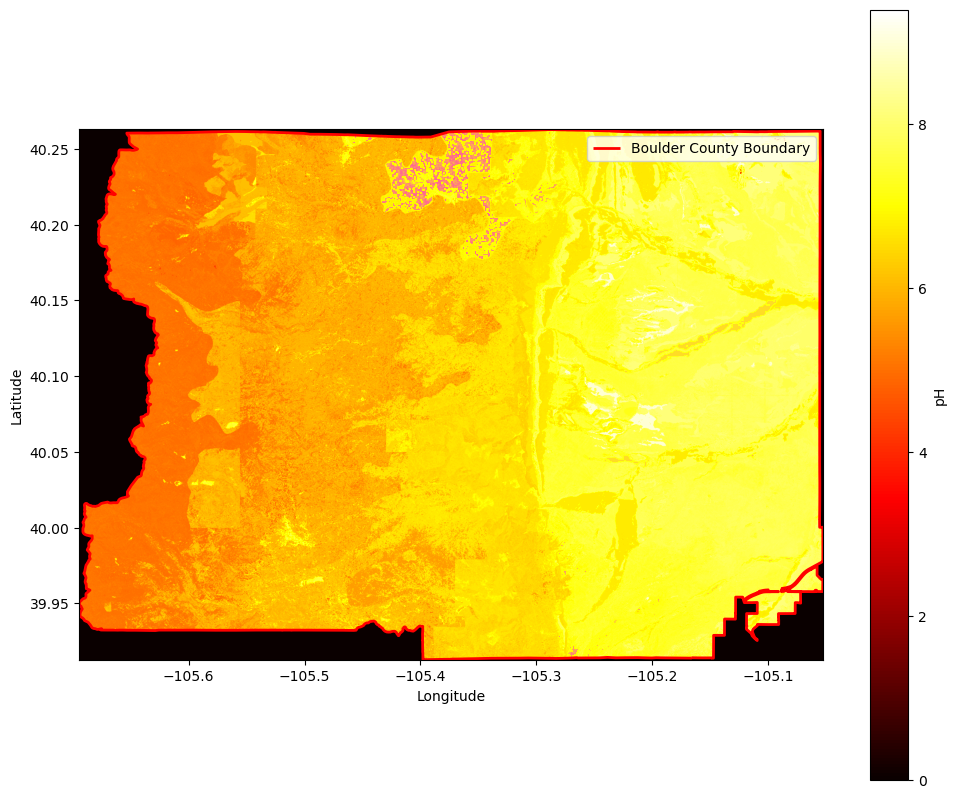

In [4]:
import os
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

# Filepath to the merged raster file
download_dir = 'soil_data'
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Clip pH values to the range 0-16
data = np.clip(data, 0, 16)

# Create a mask for pH values in the range [6.8, 7.2]
highlight_mask = (data >= 6.8) & (data <= 7.2)

# Save the masked data to a new GeoTIFF file
output_filepath = os.path.join(os.getcwd(), "boulder_soil_data.tif")

with rasterio.open(output_filepath, "w", **meta) as dest:
    dest.write(data, 1)  # Write the data to the first band
    dest.nodata = nodata_value  # Set the no-data value

print(f"GeoTIFF saved to {output_filepath}")

# Reprojection to UTM Zone 13N
utm_crs = "EPSG:26913"  # UTM Zone 13N
reprojected_filepath = os.path.join(os.getcwd(), "boulder_soil_data_utm.tif")

with rasterio.open(output_filepath) as src:
    # Calculate the transform and new metadata for the reprojected file
    transform, width, height = calculate_default_transform(
        src.crs, utm_crs, src.width, src.height, *src.bounds
    )
    
    meta = src.meta.copy()
    meta.update({
        "crs": utm_crs,
        "transform": transform,
        "width": width,
        "height": height,
    })

    # Reproject the data to UTM Zone 13N
    with rasterio.open(reprojected_filepath, "w", **meta) as dest:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dest, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=utm_crs,
                resampling=Resampling.nearest,
            )

print(f"Reprojected GeoTIFF saved to {reprojected_filepath}")

# Plotting (optional)
import matplotlib.pyplot as plt

# Plot the clipped data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the soil raster using imshow instead of show()
soil_img = ax.imshow(
    data,
    cmap="hot",  # Set warm colors (e.g., "hot" colormap)
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=1.0,  # Full opacity for the soil data
)

# Overlay highlighted areas (6.8-7.2 range)
highlight_overlay = np.ma.masked_where(~highlight_mask, data)  # Mask areas outside the range
ax.imshow(
    highlight_overlay,
    cmap="spring",  # Bright green/pink colormap for the highlight
    extent=(
        out_transform[2],
        out_transform[2] + out_transform[0] * data.shape[1],
        out_transform[5] + out_transform[4] * data.shape[0],
        out_transform[5],
    ),
    origin="upper",
    alpha=0.6,  # Transparency for overlay
)

# Plot the Boulder County boundary
boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add a legend and labels
ax.legend()
plt.colorbar(soil_img, ax=ax, label="pH")  # Use the mappable object (soil_img) for colorbar
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [5]:
import os
import rasterio
import numpy as np
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import mapping

# Filepath to the merged raster file
download_dir = 'soil_data'
merged_filepath = os.path.join(download_dir, "merged_soil_data.tif")

# Open the raster file and apply processing
with rasterio.open(merged_filepath) as src:
    # Reproject Boulder County boundary to the raster's CRS
    soil_crs = src.crs  # CRS of the soil raster
    boulder_reproject_gdf = boulder_gdf.to_crs(soil_crs)
    
    # Create a geometry mask for Boulder County
    boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]
    
    # Mask the raster to only include data within Boulder County
    data, out_transform = mask(src, boulder_geometry, crop=True)
    data = data[0]  # Extract the first band (assuming single-band data)
    meta = src.meta.copy()
    meta.update(
        {
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform,
        }
    )

# Mask no-data values (assuming -9999 is the no-data value; update if different)
nodata_value = meta.get("nodata", -9999)
data = np.where(data == nodata_value, np.nan, data)

# Reclassify values based on the specified pH ranges
output_data = np.zeros_like(data)  # Initialize with zeros (value for all other areas)

# Assign values for specific ranges
output_data[(data >= 6.8) & (data <= 7.2)] = 1    # Value of 1 for pH 6.8-7.2
output_data[((data >= 6.5) & (data < 6.8)) | 
            ((data > 7.2) & (data <= 7.5))] = 0.5  # Value of 0.5 for pH 6.5-6.8 and 7.2-7.5

# Update metadata to set data type to Float32 for fractional values
meta.update(dtype='float32', nodata=0)

# Save the reclassified data to a new GeoTIFF file
output_filepath = os.path.join(os.getcwd(), "boulder_soil_reclassified.tif")
with rasterio.open(output_filepath, "w", **meta) as dest:
    dest.write(output_data.astype('float32'), 1)

print(f"Reclassified GeoTIFF saved to {output_filepath}")

# Reproject the GeoTIFF to EPSG:32613 (WGS 84 / UTM zone 13N)
utm_crs = "EPSG:32613"
reprojected_filepath = os.path.join(os.getcwd(), "boulder_soil_reclassified_utm.tif")

with rasterio.open(output_filepath) as src:
    # Calculate the transform and new metadata for the reprojected file
    transform, width, height = calculate_default_transform(
        src.crs, utm_crs, src.width, src.height, *src.bounds
    )
    
    meta = src.meta.copy()
    meta.update({
        "crs": utm_crs,
        "transform": transform,
        "width": width,
        "height": height,
    })

    # Reproject the data to UTM Zone 13N
    with rasterio.open(reprojected_filepath, "w", **meta) as dest:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dest, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=utm_crs,
            resampling=Resampling.nearest,
        )

print(f"Reprojected GeoTIFF saved to {reprojected_filepath}")


C:\Users\gpaul\AppData\Local\Temp\ipykernel_30624\661884000.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boulder_geometry = [mapping(boulder_reproject_gdf.unary_union)]


Reclassified GeoTIFF saved to c:\Users\gpaul\Documents\GitHub\bluespruce\boulder_soil_reclassified.tif
Reprojected GeoTIFF saved to c:\Users\gpaul\Documents\GitHub\bluespruce\boulder_soil_reclassified_utm.tif


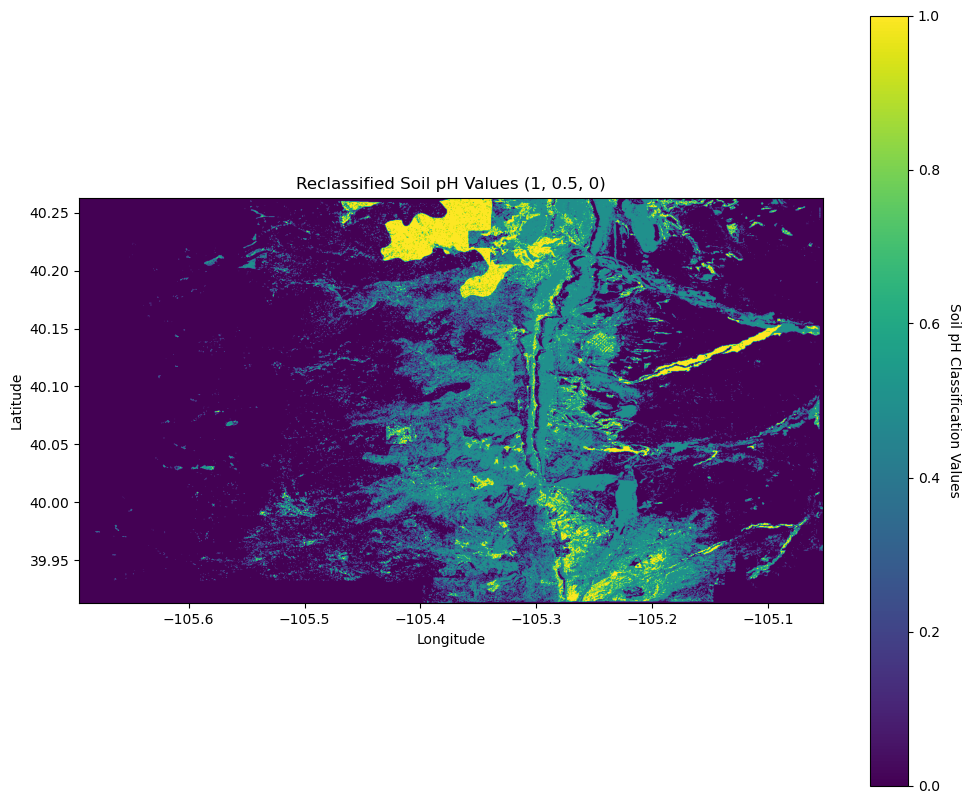

In [6]:
import matplotlib.pyplot as plt

# Plotting the reclassified raster data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the reclassified soil data
soil_img = ax.imshow(
    output_data,  # The reclassified data
    cmap="viridis",  # Choose a colormap (e.g., "viridis" for a perceptually uniform colormap)
    extent=(
        out_transform[2],  # Left bound
        out_transform[2] + out_transform[0] * output_data.shape[1],  # Right bound
        out_transform[5] + out_transform[4] * output_data.shape[0],  # Bottom bound
        out_transform[5],  # Top bound
    ),
    origin="upper",  # Set origin to upper-left
    alpha=1.0,  # Full opacity for the raster
)

# Add a colorbar to show the scale of reclassified values
cbar = plt.colorbar(soil_img, ax=ax)
cbar.set_label("Soil pH Classification Values", rotation=270, labelpad=15)

# Optional: Overlay the Boulder County boundary (if needed)
# boulder_reproject_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2, label="Boulder County Boundary")

# Add labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Reclassified Soil pH Values (1, 0.5, 0)")

# Show the plot
plt.show()
